In [2]:
import cv2 
from matplotlib import pyplot as plt 
import numpy as np 

In [31]:
def read_img(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    return img

In [32]:
img_1 = read_img(r'C:\Users\richa\OneDrive\Documentos\Computer Vision\Computer-Vision-Course\Task_05\imagens\IMG_1.jpg')
img_2 = read_img(r'C:\Users\richa\OneDrive\Documentos\Computer Vision\Computer-Vision-Course\Task_05\imagens\IMG_2.jpg')


> # Calculate the points and matcher 

> SIFT algorithm

In [5]:
def show_img(img):
    plt.figure(figsize = (10,6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [5]:
def matching_sift(img1, img2,n_features, edgeThreshold):
    # Starting the sift algorithm
    sift = cv2.xfeatures2d.SIFT_create(nfeatures =n_features, edgeThreshold=edgeThreshold )

    key_points_1,descriptors_1 = sift.detectAndCompute(img1,None)
    key_points_2,descriptors_2 = sift.detectAndCompute(img2,None)

    # Starting Brute force matcher between the key_points 
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors_1,descriptors_2,k=2)


    # applying the ratio test 
    good = []

    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])

    # Drawing the matches points  
    final_img = cv2.drawMatchesKnn(img1,key_points_1,img2,key_points_2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return final_img

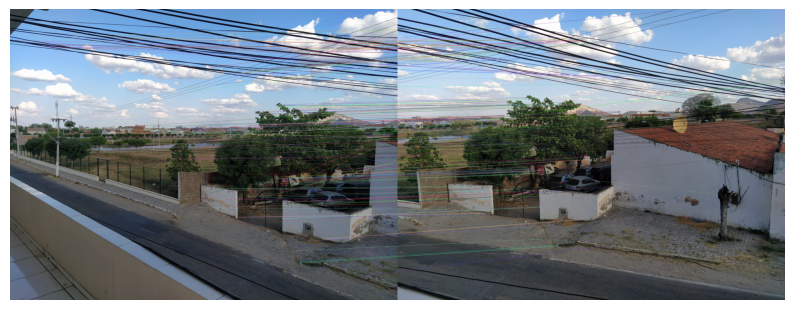

In [6]:
# Show image 
show_img(matching_sift(img_1,img_2, n_features =3000, edgeThreshold=15))

> SURF algorithm

In [24]:
def matching_surf(img1, img2):
    # Starting the sift algorithm
    surf = cv2.xfeatures2d.SURF_create(400)

    key_points_1,descriptors_1 = surf.detectAndCompute(img1,None)
    key_points_2,descriptors_2 = surf.detectAndCompute(img2,None)

    # Starting Brute force matcher between the key_points 
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)


    matches = bf.match(descriptors_1,descriptors_2)

    matches = sorted(matches, key = lambda x:x.distance)
     
    # Drawing the matches points  
    final_img = cv2.drawMatches(img1,key_points_1,img2,key_points_2,matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return final_img

In [26]:
show_img(matching_surf(img_1, img_2))

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv_contrib\modules\xfeatures2d\src\surf.cpp:1029: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SURF::create'


> KAZE algorithm

> AKAZE algorithm

In [22]:
def matching_akaze(img1, img2):
    # Initiate A-KAZE descriptor
    AKAZE = cv2.AKAZE_create()

    # Find the keypoints and compute the descriptors for input and training-set image
    keypoints1, descriptors1 = AKAZE.detectAndCompute(img1, None)
    keypoints2, descriptors2 = AKAZE.detectAndCompute(img1, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1

    index_params = dict(algorithm = FLANN_INDEX_KDTREE,
                        trees = 5)

    search_params = dict(checks = 50)

    # Convert to float32
    descriptors1 = np.float32(descriptors1)
    descriptors2 = np.float32(descriptors2)

    # Create FLANN object
    FLANN = cv2.FlannBasedMatcher(indexParams = index_params,
                                 searchParams = search_params)

    # Matching descriptor vectors using FLANN Matcher
    matches = FLANN.knnMatch(queryDescriptors = descriptors1,
                            trainDescriptors = descriptors2,
                            k = 2)

    # Lowe's ratio test
    ratio_thresh = 0.7

    # "Good" matches
    good_matches = []

    # Filter matches
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    # Draw only "good" matches
    output = cv2.drawMatches(img1 = img1,
                            keypoints1 = keypoints1,
                            img2 = img2,
                            keypoints2 = keypoints2,
                            matches1to2 = good_matches,
                            outImg = None,
                            flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return output
    


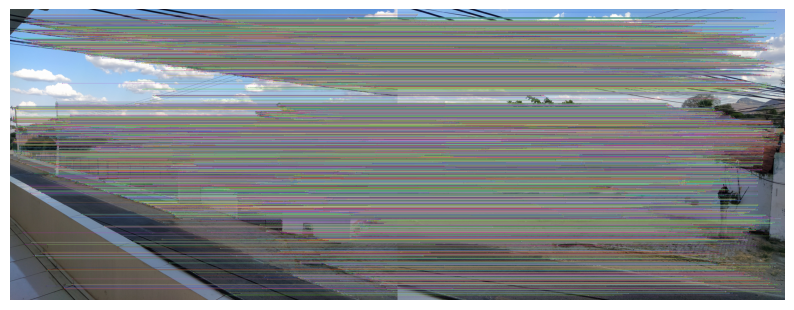

In [23]:
show_img(matching_akaze(img_1, img_2))

>  ORB algorithm

In [6]:
def matching_orb(img1, img2, nfeatures):
    # Starting the sift algorithm
    orb = cv2.ORB_create(nfeatures=nfeatures)

    key_points_1,descriptors_1 = orb.detectAndCompute(img1,None)
    key_points_2,descriptors_2 = orb.detectAndCompute(img2,None)

    # Starting Brute force matcher between the key_points 
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)


    matches = bf.match(descriptors_1,descriptors_2)

    matches = sorted(matches, key = lambda x:x.distance)
     
    # Drawing the matches points  
    final_img = cv2.drawMatches(img1,key_points_1,img2,key_points_2,matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return final_img

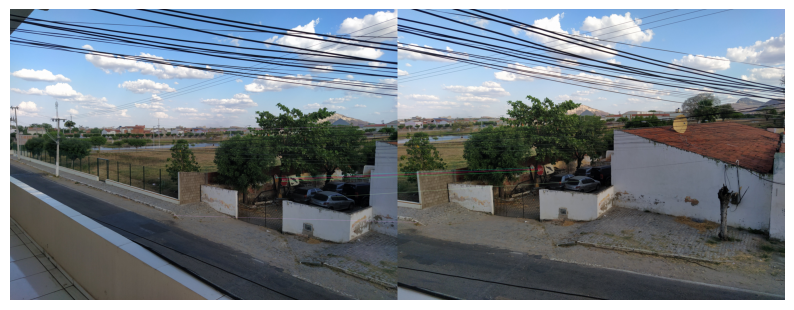

In [7]:
show_img(matching_orb(img_1, img_2,nfeatures=20000))

> BRISK algorithm

In [35]:
def matching_brisk(img_1, img_2):
    BRISK = cv2.BRISK_create()

    # Find the keypoints and compute the descriptors for input and training-set image
    keypoints1, descriptors1 = BRISK.detectAndCompute(img_1, None)
    keypoints2, descriptors2 = BRISK.detectAndCompute(img_2, None)

    # create BFMatcher object
    BFMatcher = cv2.BFMatcher(normType = cv2.NORM_HAMMING,
                            crossCheck = True)

    # Matching descriptor vectors using Brute Force Matcher
    matches = BFMatcher.match(queryDescriptors = descriptors1,
                            trainDescriptors = descriptors2)

    # Sort them in the order of their distance
    matches = sorted(matches, key = lambda x: x.distance)

    # Draw first 15 matches
    output = cv2.drawMatches(img1 = img_1,
                            keypoints1 = keypoints1,
                            img2 = img_2,
                            keypoints2 = keypoints2,
                            matches1to2 = matches[:15],
                            outImg = None,
                            flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return output



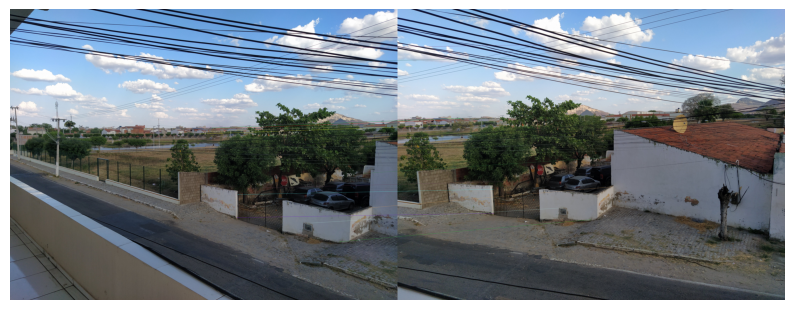

In [36]:
show_img(matching_brisk(img_1, img_2))